<a href="https://colab.research.google.com/github/jawaharganesh24189/DLA/blob/dev/8C_Building_and_Saving_our_Third_Language_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.0 Background


In the previous discussions,
1. We learned how to convert text data to numeric inputs.
2. We learned about sequence models - LSTM
3. We learned how to use LSTM to predict a number (forecasting problem) and a class (text classification problem)
4. In the text classification model, We had use a embedding layer within LSTM for text encoding
5. However, text classification is, in many ways, a uniquely simple problem.
6. We only need to output a single floating-point number for binary classification and, at worst, N numbers for N-way classification.
7. We have seen one example of seq2seq model using RNN
8. We had developed a translation model with LSTM
9. We shall use similar priniciples to develop a translation model with a Transformer

Source Code: Deep Learning with Python, Third Edition, François Chollet Matthew Watson, Chapter 15

# 2.0 General Template of a Seq2Seq model

1. An encoder model turns the source sequence into an intermediate representation.
2. A decoder is trained using the language modeling setup we saw previously.
It will recursively predict the next token in the target sequence by looking
at all previous target tokens and our encoder’s representation of the source
sequence.
3. During inference, we don’t have access to the target sequence—we’re trying to predict it from scratch. We will generate it one token at a time, just as we did with our Shakespeare generator:
    *  We obtain the encoded source sequence from the encoder.
    *  The decoder starts by looking at the encoded source sequence as well as an initial “seed” token (such as the string "[start]") and uses them to predict the first real token in the sequence.
    *  The predicted sequence so far is fed back into the decoder, in a loop, until it generates a stop token (such as the string "[end]").






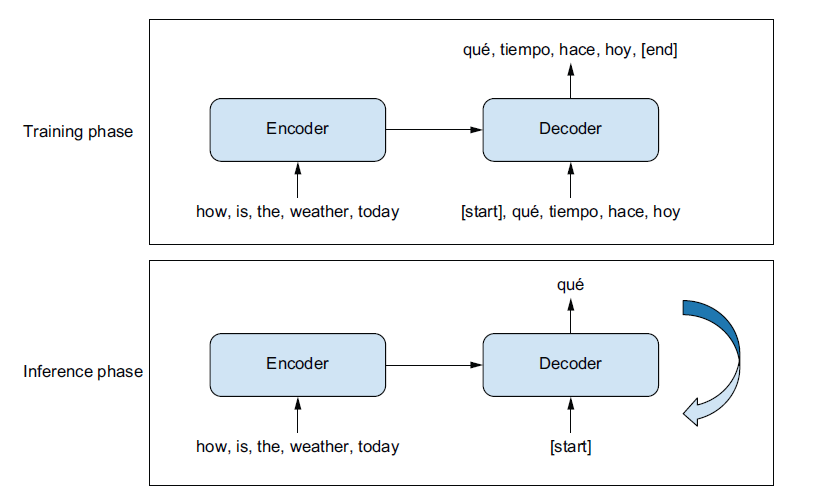

Sequence-to-sequence learning: the source sequence is processed by the encoder and
is then sent to the decoder. The decoder looks at the target sequence so far and predicts the target
sequence offset by one step in the future. During inference, we generate one target token at a time and
feed it back into the decoder.

# 3.0 Translation Model

In [ ]:
# English to Spanish Translation

import keras
import pathlib
zip_path = keras.utils.get_file(
origin=("http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip"
),fname="spa-eng",extract=True,)
text_path = pathlib.Path(zip_path) / "spa-eng" / "spa.txt"

In [ ]:
# Looking at the data

with open(text_path) as f:
  lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
  english, spanish = line.split("\t")
  spanish = "[start] " + spanish + " [end]"
  text_pairs.append((english, spanish))

import random
random.choice(text_pairs)

('She is at most 18 years old.', '[start] Ella tiene a lo más 18 años. [end]')

In [ ]:
# Let’s shuffle them and split them into the usual training, validation, and test sets:
random.shuffle(text_pairs)
val_samples = int(0.15 * len(text_pairs))
train_samples = len(text_pairs) - 2 * val_samples
train_pairs = text_pairs[:train_samples]
val_pairs = text_pairs[train_samples : train_samples + val_samples]
test_pairs = text_pairs[train_samples + val_samples :]

In [ ]:
# let’s prepare two separate TextVectorization layers: one for English and one for Spanish.

In [ ]:
# Learning token vocabularies for English and Spanish text

import string
import re

import tensorflow as tf
from tensorflow.keras import layers

strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
  lowercase = tf.strings.lower(input_string)
  return tf.strings.regex_replace(
    lowercase, f"[{re.escape(strip_chars)}]", "")

vocab_size = 15000
sequence_length = 20

english_tokenizer = layers.TextVectorization(
max_tokens=vocab_size,
output_mode="int",
output_sequence_length=sequence_length,
)

spanish_tokenizer = layers.TextVectorization(
max_tokens=vocab_size,
output_mode="int",
output_sequence_length=sequence_length + 1,
standardize=custom_standardization,
)

train_english_texts = [pair[0] for pair in train_pairs]
train_spanish_texts = [pair[1] for pair in train_pairs]

english_tokenizer.adapt(train_english_texts)
spanish_tokenizer.adapt(train_spanish_texts)

In [ ]:
# Tokenizing and preparing the translation data

In [ ]:
batch_size = 64

def format_dataset(eng, spa):
  eng = english_tokenizer(eng)
  spa = spanish_tokenizer(spa)
  features = {"english": eng, "spanish": spa[:, :-1]}
  labels = spa[:, 1:]
  sample_weights = labels != 0
  return features, labels, sample_weights

def make_dataset(pairs):
  eng_texts, spa_texts = zip(*pairs)
  eng_texts = list(eng_texts)
  spa_texts = list(spa_texts)
  dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
  dataset = dataset.batch(batch_size)
  dataset = dataset.map(format_dataset, num_parallel_calls=4)
  return dataset.shuffle(2048).cache()

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [ ]:
inputs, targets, sample_weights = next(iter(train_ds))
print(inputs["english"].shape)
print(inputs["spanish"].shape)
print(targets.shape)
print(sample_weights.shape)

(64, 20)
(64, 20)
(64, 20)
(64, 20)


# 4.0 The Transformer

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## 4.1 Transformer Encoder Block

In [ ]:
@tf.keras.utils.register_keras_serializable()
class TransformerEncoder(keras.layers.Layer):
    def __init__(self, hidden_dim, intermediate_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.hidden_dim = hidden_dim
        self.intermediate_dim = intermediate_dim
        self.num_heads = num_heads

        key_dim = hidden_dim // num_heads
        self.self_attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)
        self.self_attention_layernorm = layers.LayerNormalization()
        self.feed_forward_1 = layers.Dense(intermediate_dim, activation="relu")
        self.feed_forward_2 = layers.Dense(hidden_dim)
        self.feed_forward_layernorm = layers.LayerNormalization()

    def call(self, source, source_mask):
        residual = x = source
        mask = source_mask[:, None, :]
        x = self.self_attention(query=x, key=x, value=x, attention_mask=mask)
        x = x + residual
        x = self.self_attention_layernorm(x)

        residual = x
        x = self.feed_forward_1(x)
        x = self.feed_forward_2(x)
        x = x + residual
        x = self.feed_forward_layernorm(x)
        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            "hidden_dim": self.hidden_dim,
            "intermediate_dim": self.intermediate_dim,
            "num_heads": self.num_heads,
        })
        return config

## 4.2 Transformer decoder block

In [ ]:
@tf.keras.utils.register_keras_serializable()
class TransformerDecoder(keras.layers.Layer):
    def __init__(self, hidden_dim, intermediate_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.hidden_dim = hidden_dim
        self.intermediate_dim = intermediate_dim
        self.num_heads = num_heads

        key_dim = hidden_dim // num_heads
        self.self_attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)
        self.self_attention_layernorm = layers.LayerNormalization()
        self.cross_attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)
        self.cross_attention_layernorm = layers.LayerNormalization()
        self.feed_forward_1 = layers.Dense(intermediate_dim, activation="relu")
        self.feed_forward_2 = layers.Dense(hidden_dim)
        self.feed_forward_layernorm = layers.LayerNormalization()

    def call(self, target, source, source_mask):
        residual = x = target
        x = self.self_attention(query=x, key=x, value=x, use_causal_mask=True)
        x = x + residual
        x = self.self_attention_layernorm(x)

        residual = x
        mask = source_mask[:, None, :]
        x = self.cross_attention(query=x, key=source, value=source, attention_mask=mask)
        x = x + residual
        x = self.cross_attention_layernorm(x)

        residual = x
        x = self.feed_forward_1(x)
        x = self.feed_forward_2(x)
        x = x + residual
        x = self.feed_forward_layernorm(x)
        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            "hidden_dim": self.hidden_dim,
            "intermediate_dim": self.intermediate_dim,
            "num_heads": self.num_heads,
        })
        return config

## 4.3 Embedding positional information

In [ ]:
@tf.keras.utils.register_keras_serializable()
class PositionalEmbedding(keras.layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.token_embeddings = layers.Embedding(input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(input_dim=sequence_length, output_dim=output_dim)

    def call(self, inputs):
        seq_len = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=seq_len, delta=1)
        pos_embeddings = self.position_embeddings(positions)
        token_embeddings = self.token_embeddings(inputs)
        return token_embeddings + pos_embeddings

    def get_config(self):
        config = super().get_config()
        config.update({
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
            "output_dim": self.output_dim,
        })
        return config


## 4.4 Sequence-to-sequence learning with a Transformer

In [ ]:
hidden_dim = 256
intermediate_dim = 2056
num_heads = 8

source = keras.Input(shape=(None,), dtype="int32", name="english")
x = PositionalEmbedding(sequence_length, vocab_size, hidden_dim)(source)
encoder_output = TransformerEncoder(hidden_dim, intermediate_dim, num_heads)(
    source=x,
    source_mask=source != 0,
)

target = keras.Input(shape=(None,), dtype="int32", name="spanish")
x = PositionalEmbedding(sequence_length, vocab_size, hidden_dim)(target)
x = TransformerDecoder(hidden_dim, intermediate_dim, num_heads)(
    target=x,
    source=encoder_output,
    source_mask=source != 0,
)
x = layers.Dropout(0.5)(x)
target_predictions = layers.Dense(vocab_size, activation="softmax")(x)
transformer = keras.Model([source, target], target_predictions)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/MyDrive/DLA_Notebooks_Data_PGPM/transformer_best.keras",
    monitor="val_loss",
    save_best_only=True
)

transformer.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    weighted_metrics=["accuracy"],
)

history = transformer.fit(
    train_ds,
    epochs=30,
    validation_data=val_ds,
    callbacks=[early_stopping, checkpoint_cb]
)


Epoch 1/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 80s 50ms/step - accuracy: 0.2880 - loss: 1.7571 - val_accuracy: 0.5248 - val_loss: 0.9815
Epoch 2/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 55s 42ms/step - accuracy: 0.5405 - loss: 0.9759 - val_accuracy: 0.6100 - val_loss: 0.7672
Epoch 3/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 54s 41ms/step - accuracy: 0.6258 - loss: 0.7409 - val_accuracy: 0.6458 - val_loss: 0.6894
Epoch 4/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 54s 42ms/step - accuracy: 0.6720 - loss: 0.6092 - val_accuracy: 0.6609 - val_loss: 0.6524
Epoch 5/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 54s 42ms/step - accuracy: 0.7031 - loss: 0.5250 - val_accuracy: 0.6715 - val_loss: 0.6353
Epoch 6/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 54s 42ms/step - accuracy: 0.7258 - loss: 0.4646 - val_accuracy: 0.6785 - val_loss: 0.6284
Epoch 7/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 53s 41ms/step - accuracy: 0.7450 - loss: 0.4163 - val_accuracy: 0.6781 - val_loss: 0.6295
Epoch 8/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 53s 41ms/step - accuracy: 0.7639 -

In [ ]:
transformer.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    weighted_metrics=["accuracy"],
)
transformer.fit(train_ds, epochs=30, validation_data=val_ds)

Epoch 1/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 75s 46ms/step - accuracy: 0.2806 - loss: 1.7819 - val_accuracy: 0.5268 - val_loss: 0.9784
Epoch 2/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 50s 38ms/step - accuracy: 0.5405 - loss: 0.9808 - val_accuracy: 0.6149 - val_loss: 0.7573
Epoch 3/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 51s 39ms/step - accuracy: 0.6264 - loss: 0.7406 - val_accuracy: 0.6461 - val_loss: 0.6795
Epoch 4/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 50s 38ms/step - accuracy: 0.6727 - loss: 0.6087 - val_accuracy: 0.6624 - val_loss: 0.6423
Epoch 5/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 50s 39ms/step - accuracy: 0.7042 - loss: 0.5227 - val_accuracy: 0.6703 - val_loss: 0.6288
Epoch 6/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 50s 39ms/step - accuracy: 0.7283 - loss: 0.4595 - val_accuracy: 0.6759 - val_loss: 0.6219
Epoch 7/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 51s 39ms/step - accuracy: 0.7479 - loss: 0.4114 - val_accuracy: 0.6789 - val_loss: 0.6274
Epoch 8/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 51s 39ms/step - accuracy: 0.7661 -

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Save Model
model_path = "/content/drive/MyDrive/DLA_Notebooks_Data_PGPM/transformer.keras"
transformer.save(model_path)

In [ ]:
# Save Tokenizers
import json

eng_vocab_path = "/content/drive/MyDrive/DLA_Notebooks_Data_PGPM/eng_vocab_t.json"
spa_vocab_path = "/content/drive/MyDrive/DLA_Notebooks_Data_PGPM/spa_vocab_t.json"

with open(eng_vocab_path, "w") as f:
     json.dump(english_tokenizer.get_vocabulary(), f)

with open(spa_vocab_path, "w") as f:
     json.dump(spanish_tokenizer.get_vocabulary(), f)


In [ ]:
import tensorflow as tf
import json
from tensorflow.keras.layers import TextVectorization

# --- Paths ---
model_path = "/content/drive/MyDrive/DLA_Notebooks_Data_PGPM/transformer.keras"
eng_vocab_path = "/content/drive/MyDrive/DLA_Notebooks_Data_PGPM/eng_vocab_t.json"
spa_vocab_path = "/content/drive/MyDrive/DLA_Notebooks_Data_PGPM/spa_vocab_t.json"

# --- Load model with custom objects ---
transformer = tf.keras.models.load_model(
    model_path,
    custom_objects={
        "TransformerEncoder": TransformerEncoder,
        # include if they exist in your training code:
        "TransformerDecoder": TransformerDecoder,
        "PositionalEmbedding": PositionalEmbedding,
    },
)

# --- Load vocabularies ---
with open(eng_vocab_path) as f:
    eng_vocab = json.load(f)

with open(spa_vocab_path) as f:
    spa_vocab = json.load(f)

# --- Recreate tokenizers ---
english_tokenizer = TextVectorization(
    max_tokens=len(eng_vocab),
    output_mode="int",
    output_sequence_length=20
)

spanish_tokenizer = TextVectorization(
    max_tokens=len(spa_vocab),
    output_mode="int",
    output_sequence_length=20
)

english_tokenizer.set_vocabulary(eng_vocab)
spanish_tokenizer.set_vocabulary(spa_vocab)

spa_index_lookup = {i: tok for i, tok in enumerate(spa_vocab)}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'positional_embedding_3', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'transformer_encoder_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'positional_embedding

In [ ]:
import numpy as np

spa_vocab = spanish_tokenizer.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))

def generate_translation(input_sentence):
    tokenized_input_sentence = english_tokenizer([input_sentence])
    decoded_sentence = "[start]"
    for i in range(sequence_length):
        tokenized_target_sentence = spanish_tokenizer([decoded_sentence])
        tokenized_target_sentence = tokenized_target_sentence[:, :-1]
        inputs = [tokenized_input_sentence, tokenized_target_sentence]
        next_token_predictions = transformer.predict(inputs, verbose=0)
        sampled_token_index = np.argmax(next_token_predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence



In [ ]:
# Obtaining Translations

sequence_length = 200
input_sentence ="You did not hear that from me"
print("-")                                     #Prints a separator
print(input_sentence)                          #Prints the source sentence.
print(generate_translation(input_sentence))    #Prints the translated sentence

-
You did not hear that from me
[start] de no me escuchaste eso [end]
